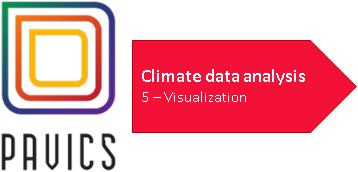
<a id='top'></a>

ADD descr. 

This tutorial outlines steps for visualizing and summarizing climate data into usable information and visualizatinons including:

* [Maps of climate normals](#maps)
* [Time-series plots](#timeseries)
* [Table summaries](#tables)

___

*NOTE : To run this series of tutorials in the PAVICS jupyterhub, notebooks should be copied into your 'writable-workspace' directory*  





## Ensemble dataset preparation
We will re-use the concepts of the ensembles tutorial in a slightly more complex workflow to prepare a dataset containing climate indicator output of both RCP 4.5 and RCP 8.5 simulations

*[return to top of page](#top)*

In [1]:
# Sub function definitions
def unstack_yr_season(ds):
    """Translate resampled data to a multi-index year [int] / season [string]"""
    
    ind = pd.MultiIndex.from_arrays([ds.time.dt.year.values + (ds.time.dt.month.values == 12).astype(int),
                                          ds.time.dt.month.values],
                                         names=['year', 'season'])
    dsout = ds.assign(time=ind).unstack('time')
    if len(pd.unique(dsout.season.values)) == 12:
        seas_label = [calendar.month_name[m] for m in range(1,13)]
    else:
        all_labels = {1: 'Annual', 3: 'Spring', 6: 'Summer', 7: 'Annual (jul-jun)', 9: 'Fall', 12: 'Winter'}
        seas_label = [all_labels[m] for m in pd.unique(dsout.season.values)]
    return dsout.assign_coords(season=seas_label)


In [9]:
from xclim import ensembles as xens
import pandas as pd
from clisops.core import subset
import xarray as xr
from pathlib import Path
import numpy as np
from xclim.core import units
import panel as pn
import holoviews as hv
from holoviews import streams
import hvplot
import hvplot.pandas
import hvplot.xarray
from bokeh.models.tools import HoverTool
import warnings
import logging

logging.getLogger().disabled = True
warnings.simplefilter("ignore")

infolder = Path('output')

ds_all =[]
for rcp in ['rcp45','rcp85']:
    ds_vars = []
    for v in ['tx_mean','tx_days_above']:
        ncfiles = [d for d in infolder.glob(f'{v}*{rcp}*.nc')]

        #Create an ensemble dataset from the 11 simulations for the given rcp
        # Add a new rcp dimension and corodinate
        ds_vars.append(xens.create_ensemble(ncfiles).assign_coords(rcp=rcp).expand_dims('rcp'))
    
    # Create a single dataset with both variables
    ds_all.append(xr.merge(ds_vars))

#concatenate the 2 rcp datasets together along the new 'rcp' dim
ds_ens = xr.concat(ds_all, dim='rcp')
ds_ens

<xarray.Dataset>
Dimensions:        (lat: 12, lon: 60, rcp: 2, realization: 11, time: 481)
Coordinates:
  * time           (time) datetime64[ns] 1980-12-01 1981-03-01 ... 2100-12-01
  * lat            (lat) float32 48.96 48.87 48.79 48.71 ... 48.21 48.12 48.04
  * lon            (lon) float32 -68.96 -68.88 -68.8 ... -64.21 -64.13 -64.05
  * realization    (realization) int64 0 1 2 3 4 5 6 7 8 9 10
  * rcp            (rcp) object 'rcp45' 'rcp85'
Data variables:
    tx_mean        (rcp, realization, time, lat, lon) float32 dask.array<chunksize=(1, 1, 481, 12, 60), meta=np.ndarray>
    tx_days_above  (rcp, realization, time, lat, lon) float64 dask.array<chunksize=(1, 1, 481, 12, 60), meta=np.ndarray>

<a id='maps'></a>
## Maps of climate normals
In this section we examine steps to create an interactive map of 30 year climatologies. First we calculate 30 year averages on our ensemble dataset
as well as a subsequent delta change calculation with respect to a reference period. We then calculate ensembles percentiles of the 30 year normals. Finally we employ [holoviz](https://holoviz.org/) tools to create an interactive figure to explore the data

*Notes : "Unstacking" the time dimension via the custom sub-function `unstack_yr_season` allows us to calculate 30 year averages for all seasons simultaneously with `xarray` operations such as [rolling](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.rolling.html) or [coarsen](https://xarray.pydata.org/en/v0.12.0/generated/xarray.Dataset.coarsen.html)*

*[return to top of page](#top)*

In [31]:
# 30 year means and delta calculations
ds2d = unstack_yr_season(ds_ens)
window = 30
d30yAvg = ds2d.rolling(year=window).mean().sel(year=slice(ds2d.year[0]+window-1,2100))
horizons = xr.DataArray([f'{yr - 29}-{yr}' for yr in d30yAvg.year.values], dims=dict(year=d30yAvg.year))
d30yAvg = d30yAvg.assign_coords(horizon=horizons)
# Select every horizons in 10 y intervals
d30yAvg = d30yAvg.sel(year=(d30yAvg.year.values%10==0))
for v in d30yAvg.data_vars:
    if units.units2pint(d30yAvg[v]) == 'kelvin':
        d30yAvg[v] = units.convert_units_to(d30yAvg[v], 'degC')

# Calculate deltas
ref = d30yAvg.sel(year=(d30yAvg.horizon=='1981-2010')).squeeze()
for v in d30yAvg.data_vars:
    with xr.set_options(keep_attrs=True):
        d30yAvg[f"{v}_delta"]= d30yAvg[v] - ref[v]
        for a in ['description', 'long_name']:
            d30yAvg[f"{v}_delta"].attrs[a] = f"{d30yAvg[f'{v}_delta'].attrs[a]} : delta vs 1981-2010"
        

# Calculate percentiles on 30y normals
d30yAvg = xens.ensemble_percentiles(d30yAvg, split=False).load()
display(d30yAvg)

<xarray.Dataset>
Dimensions:              (lat: 12, lon: 60, percentiles: 3, rcp: 2, season: 4, year: 10)
Coordinates:
  * lat                  (lat) float32 48.96 48.87 48.79 ... 48.21 48.12 48.04
  * lon                  (lon) float32 -68.96 -68.88 -68.8 ... -64.13 -64.05
  * rcp                  (rcp) object 'rcp45' 'rcp85'
  * year                 (year) int64 2010 2020 2030 2040 ... 2080 2090 2100
  * season               (season) <U6 'Spring' 'Summer' 'Fall' 'Winter'
    horizon              (year) <U9 '1981-2010' '1991-2020' ... '2071-2100'
  * percentiles          (percentiles) int64 10 50 90
Data variables:
    tx_mean              (rcp, lat, lon, year, season, percentiles) float64 5...
    tx_days_above        (rcp, lat, lon, year, season, percentiles) float64 0...
    tx_mean_delta        (rcp, lat, lon, year, season, percentiles) float64 0...
    tx_days_above_delta  (rcp, lat, lon, year, season, percentiles) float64 0...
Attributes:
    xclim_history:  [2021-02-17 23:32:11] : Computation of the percentiles on...

In [37]:
## Create interactive map using holoviz tools

## widgets setup
# variable menu
vars = pn.widgets.Select(options=[v for v in list(d30yAvg.data_vars.keys()) if '_delta' not in v], width=125)
vars1 = pn.Column(pn.pane.Markdown('**variable**'),vars)

# delta checkbox
delta = pn.widgets.Checkbox(value=False)
delta1 = pn.Column(pn.pane.Markdown('**display deltas**'),delta)
# seasons menu
seasons = pn.widgets.Select(options=list(d30yAvg.season.values), value='Summer', width=125)
seasons1 = pn.Column(pn.pane.Markdown('**season**'),seasons)

# percentiles menu
perc = pn.widgets.RadioButtonGroup(options=list(d30yAvg.percentiles.values), value=50, width=125)
perc1 = pn.Column(pn.pane.Markdown('**ensemble percentile**'),perc)

# horizons menu
hors = pn.widgets.DiscreteSlider(options=list(d30yAvg.horizon.values), value='2041-2070', width=200)
hors1 = pn.Column(pn.pane.Markdown('**horizon**'),hors)

# rcps menu
rcps = pn.widgets.RadioButtonGroup(options=list(d30yAvg.rcp.values), value='rcp85', width=125)
rcps1 = pn.Column(pn.pane.Markdown('**emissions scenario**'),rcps)

# transparency 
trs = pn.widgets.FloatInput(value=0.8, start=0.0, end=1.0, step=0.2, width = 60)
trs1 = pn.Column(pn.pane.Markdown('opacity'),trs)

## Dynamically change map using pn.depends decorator
@pn.depends(vars.param.value, seasons.param.value, perc.param.value, 
            hors.param.value, rcps.param.value, trs.param.value, delta.param.value)
def plot_map(v=vars.param.value, s=seasons.param.value, p=perc.param.value, h=hors.param.value, 
             r=rcps.param.value, alpha=trs.param.value, delta_flag=delta.param.value):   
    out = d30yAvg.swap_dims(dict(year='horizon'))
    if delta_flag:
        v = f"{v}_delta"
        tool_lab = f"delta vs {ref.horizon.values} ({out[v].attrs['units']})"
    else:
        tool_lab = f"{out[v].attrs['long_name']}  ({out[v].attrs['units']})"
    clim = (out[v].sel(season=s).min().values, out[v].sel(season=s).max().values)
    out = out.sel(season=s, percentiles=p, horizon=h, rcp=r)
    hover = HoverTool(tooltips=[(tool_lab, f"@{v}")])
    title = pn.pane.Markdown(f"### {s} {out[v].attrs['long_name'].lower()} ({out[v].attrs['units'].lower()})<br/> {h} : {r} ({p}th percentile)".replace('  ',' '))
    return pn.Column(title,pn.Row(out.hvplot.quadmesh(z=v,alpha=alpha,xlabel='lon',
                                                      ylabel='lat', cmap='Spectral_r', 
                                                      clim=clim, geo=True, tiles='CartoLight', 
                                                      tools=[hover],frame_width=1000),trs1))

## Display interactive map
pn.Column(plot_map, pn.Row(vars1, seasons1, rcps1, perc1, hors1, delta1))

Column
    [0] ParamFunction(function)
    [1] Row
        [0] Column
            [0] Markdown(str)
            [1] Select(options=['tx_mean', 'tx_days_above...], value='tx_mean', width=125)
        [1] Column
            [0] Markdown(str)
            [1] Select(options=['Spring', 'Summer', ...], value='Summer', width=125)
        [2] Column
            [0] Markdown(str)
            [1] RadioButtonGroup(options=['rcp45', 'rcp85'], value='rcp85', width=125)
        [3] Column
            [0] Markdown(str)
            [1] RadioButtonGroup(options=[10, 50, 90], value=50, width=125)
        [4] Column
            [0] Markdown(str)
            [1] DiscreteSlider(options=['1981-2010', ...], value='2041-2070', value_throttled='2041-2070', width=200)
        [5] Column
            [0] Markdown(str)
            [1] Checkbox()

___
<a id='timeseries'></a>
### Regional averages and time-series graphs

  

*[return to top of page](#top)*